In [1]:
import art

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Flatten, InputLayer, Reshape

from art.estimators.classification import KerasClassifier

# if tf.executing_eagerly():
#     tf.python.framework.ops.disable_eager_execution()
tf.compat.v1.disable_eager_execution()

In [3]:
# Prepare the dataset and the model architecture.

import art
from art.utils import load_mnist

# Load the dataset, and split the test data into test and steal datasets.
(x_train, y_train), (x_test0, y_test0), _, _ = load_mnist()
len_steal = 5000
indices = np.random.permutation(len(x_test0))
x_steal = x_test0[indices[:len_steal]]
y_steal = y_test0[indices[:len_steal]]
x_test = x_test0[indices[len_steal:]]
y_test = y_test0[indices[len_steal:]]

im_shape = x_train[0].shape
def get_model(num_classes=10, c1=32, c2=64, d1=128):
    model = Sequential()
    model.add(Conv2D(c1, kernel_size=(3, 3), activation='relu', input_shape=im_shape))
    model.add(Conv2D(c2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(d1, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer="sgd",
                          metrics=['accuracy'])
    return model

In [4]:
# Train the original model.
num_epochs = 5
model = get_model(num_classes=10, c1=32, c2=64, d1=128)
print("Original model training:")
model.fit(x_train, y_train, batch_size=100, epochs=num_epochs)
print("Original model evaluation:")
print(model.evaluate(x_test, y_test))
classifier_original = KerasClassifier(model, clip_values=(0, 1), use_logits=False)

Original model training:
Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 43s 720us/sample - loss: 0.6497 - accuracy: 0.8276
Epoch 2/5
60000/60000 [==============================] - 43s 712us/sample - loss: 0.2417 - accuracy: 0.9278
Epoch 3/5
60000/60000 [==============================] - 43s 722us/sample - loss: 0.1858 - accuracy: 0.9440
Epoch 4/5
60000/60000 [==============================] - 44s 732us/sample - loss: 0.1533 - accuracy: 0.9539
Epoch 5/5
60000/60000 [==============================] - 44s 731us/sample - loss: 0.1316 - accuracy: 0.9601
Original model evaluation:


/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[0.11797760139107705, 0.9658]


In [5]:
# Stealing from the unprotected classifier.
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets

attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                   }

results = []
for len_steal in [250, 500, 1000, 2000, 4000, 5000]:
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = get_model(num_classes=10, c1=32, c2=64, d1=128)
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 250 samples
Epoch 1/5
250/250 [==============================] - 0s 959us/sample - loss: 2.3044 - accuracy: 0.0920
Epoch 2/5
250/250 [==============================] - 0s 817us/sample - loss: 2.2843 - accuracy: 0.1120
Epoch 3/5
250/250 [==============================] - 0s 822us/sample - loss: 2.2652 - accuracy: 0.1840
Epoch 4/5
250/250 [==============================] - 0s 827us/sample - loss: 2.2480 - accuracy: 0.2920
Epoch 5/5
250/250 [==============================] - 0s 820us/sample - loss: 2.2291 - accuracy: 0.3920
Probabilistic CopycatCNN : 0.33046153
Train on 250 samples
Epoch 1/5
250/250 [==============================] - 0s 985us/sample - loss: 2.2951 - accuracy: 0.1160
Epoch 2/5
250/250 [==============================] - 0s 833us/sample - loss: 2.2714 - accuracy: 0.1680
Epoch 3/5
250/250 [==============================] - 0s 822us/sample - loss: 2.2479 - accuracy: 0.2600
Epoch 4/5
250/250 [==============================] - 0s 825us/sample - loss: 2.2251 - accuracy: 

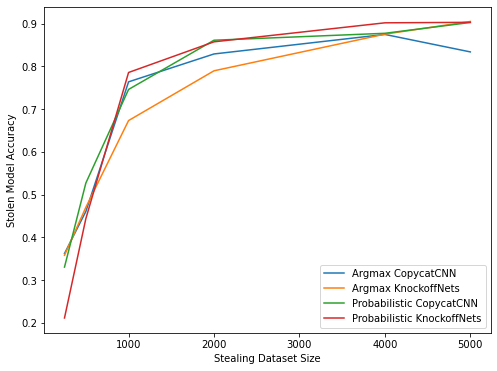

In [6]:
import pandas as pd
df = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

In [11]:
# Prepare the defense layer.
from art.defences.postprocessor import ReverseSigmoid
postprocessor = ReverseSigmoid(beta=1.0, gamma=0.2)
classifier_protected = KerasClassifier(model, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)

# Below is used by `FunctionallyEquivalentExtraction`.
model_flat = Sequential([InputLayer([784]), Reshape([28, 28, 1]), model])
model_flat.compile('sgd', 'categorical_crossentropy', ['accuracy'])
classifier_flat_protected = KerasClassifier(model_flat, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)

In [12]:
# Stealing from the protected classifier.

attack_catalogue = {
                    "Probabilistic CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
#                     "FunctionallyEquivalentExtraction": FunctionallyEquivalentExtraction(classifier=classifier_flat_protected,
#                                               num_neurons=128),  # This one takes too long time for this dataset/model.
                    }

results_protected = []
for len_steal in [250, 500, 1000, 2000, 4000, 5000]:
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = get_model(num_classes=10, c1=32, c2=64, d1=128)
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        if name=="FunctionallyEquivalentExtraction":
            classifier_stolen = attack.extract(np.reshape(x_steal, [len(x_steal), -1]), y_steal, thieved_classifier=classifier_stolen)
        else:
            classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results_protected.append((name, len_steal, acc))


Train on 250 samples
Epoch 1/5
250/250 [==============================] - 0s 1ms/sample - loss: 2.3049 - accuracy: 0.1200
Epoch 2/5
250/250 [==============================] - 0s 917us/sample - loss: 2.3044 - accuracy: 0.1160
Epoch 3/5
250/250 [==============================] - 0s 980us/sample - loss: 2.3040 - accuracy: 0.1160
Epoch 4/5
250/250 [==============================] - 0s 1ms/sample - loss: 2.3037 - accuracy: 0.1200
Epoch 5/5
250/250 [==============================] - 0s 1ms/sample - loss: 2.3034 - accuracy: 0.1200


/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Probabilistic CopycatCNN (vs. Protected) : 0.10748718
Train on 250 samples
Epoch 1/5
250/250 [==============================] - 0s 1ms/sample - loss: 2.3044 - accuracy: 0.1000
Epoch 2/5
250/250 [==============================] - 0s 830us/sample - loss: 2.2903 - accuracy: 0.1400
Epoch 3/5
250/250 [==============================] - 0s 831us/sample - loss: 2.2761 - accuracy: 0.1640
Epoch 4/5
250/250 [==============================] - 0s 872us/sample - loss: 2.2620 - accuracy: 0.1760
Epoch 5/5
250/250 [==============================] - 0s 828us/sample - loss: 2.2480 - accuracy: 0.1920
Argmax CopycatCNN (vs. Protected) : 0.18851282
Probabilistic KnockoffNets (vs. Protected) : 0.11271795
Argmax KnockoffNets (vs. Protected) : 0.41784614
Train on 500 samples
Epoch 1/5
500/500 [==============================] - 1s 1ms/sample - loss: 2.3034 - accuracy: 0.1460
Epoch 2/5
500/500 [==============================] - 0s 812us/sample - loss: 2.3031 - accuracy: 0.1520
Epoch 3/5
500/500 [================

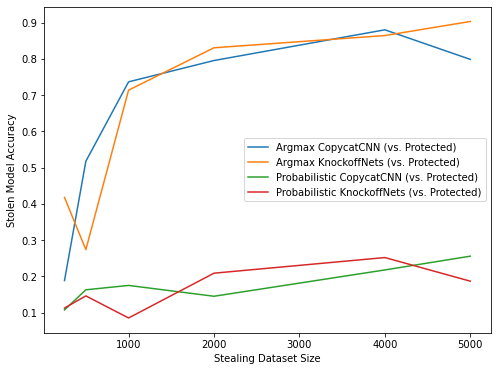

In [13]:
import pandas as pd
df_protected = pd.DataFrame(results_protected, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df_protected.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

In [14]:
df_combined = pd.concat([df, df_protected])
groupby = df_combined.groupby("Method Name")

<ipython-input-15-1207b4895878>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-15-1207b4895878>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


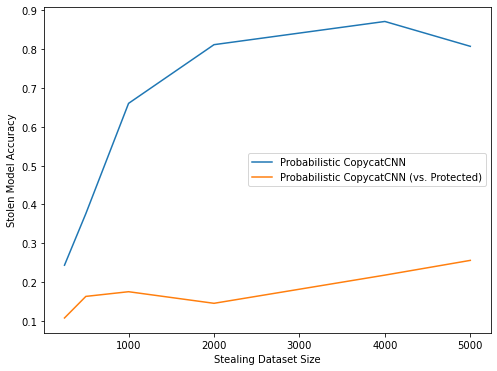

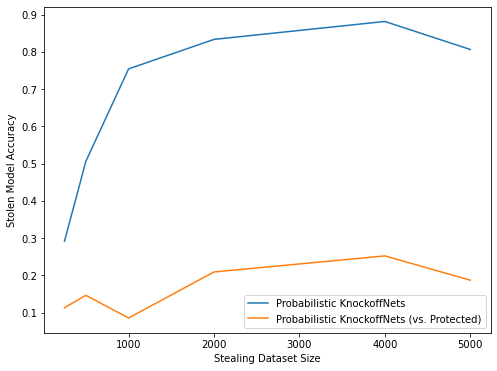

In [15]:
names = ["CopycatCNN", "KnockoffNets"]
for name in names:
    fig, ax = plt.subplots(figsize=(8,6))
    groupby.get_group("Probabilistic " + name).plot(1,2,ax=ax, label="Probabilistic " + name)
    groupby.get_group("Probabilistic " + name + " (vs. Protected)").plot(1,2,ax=ax, label="Probabilistic " + name + " (vs. Protected)")
    ax.set_xlabel("Stealing Dataset Size")
    ax.set_ylabel("Stolen Model Accuracy")
    fig.show()

In [12]:
# Next Step: Using data augmentation can make the model stealing process much easier and faster, and can make the probabilistic attack much better.